# Autonomous Highway Driving with Double Deep Q-Learning
| **Author**        | Max Spannagel                                     |
|-------------------|---------------------------------------------------|
| **Student ID**    | 6887064                                           |
| **Course**        | Reinforcement Learning                            |
| **Environment**   | Highway-v0 (highway-env)                          |
| **Algorithm**     | Double Deep Q-Network (DDQN)                      |

This notebook implements a complete training process for a reinforcement learning agent that learns to drive a vehicle autonomously on a highway. The notebook uses the Double Deep Q-Learning (DDQN) algorithm to train the agent and utilizes the OpenAI Gym `HighwayEnv` environment for simulation.

## 1. Import Libraries

In [1]:
import os
import random
import time
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

import gymnasium as gym
import highway_env

## 2. Define Hyperparameters
This section defines the hyperparameters for the DDQN agent, including learning rate, discount factor, exploration rate, and more. These parameters can be adjusted to optimize the training process. The initial values are set based on common practices.

In [2]:
CONFIG = {
    "ENV_NAME": "highway-v0",
    "LEARNING_RATE": 5e-4,       # Learning rate for the optimizer
    "GAMMA": 0.8,                # Discount factor for future rewards
    "BATCH_SIZE": 128,           # Size of the mini-batch for training
    "BUFFER_SIZE": 50000,        # Maximum size of the replay buffer
    "EPSILON_START": 1.0,        # Initial epsilon value (pure exploration)
    "EPSILON_END": 0.05,         # Final epsilon value
    "EPSILON_DECAY": 10000,      # Decay steps for epsilon
    "TARGET_UPDATE_FREQ": 1000,  # Frequency to update the target network
    "TRAINING_EPISODES": 2000,   # Number of training episodes
    "RENDER_EVERY": 20,          # Render environment every N episodes
    "SAVE_MODEL_EVERY": 100,     # Save model every N episodes
    "SAVE_VERSION_EVERY": 200,   # Save numbered model version every N episodes
    "MODEL_DIR": "models",       # Directory to save models
    "MODEL_SAVE_PATH": "models/highway_dqn_model_latest.pth"
}

# Create models directory if it doesn't exist
os.makedirs(CONFIG["MODEL_DIR"], exist_ok=True)

for key, value in CONFIG.items():
    print(f"{key}: {value}")

ENV_NAME: highway-v0
LEARNING_RATE: 0.0005
GAMMA: 0.8
BATCH_SIZE: 128
BUFFER_SIZE: 50000
EPSILON_START: 1.0
EPSILON_END: 0.05
EPSILON_DECAY: 10000
TARGET_UPDATE_FREQ: 1000
TRAINING_EPISODES: 2000
RENDER_EVERY: 20
SAVE_MODEL_EVERY: 100
SAVE_VERSION_EVERY: 200
MODEL_DIR: models
MODEL_SAVE_PATH: models/highway_dqn_model_latest.pth


## 3. Initialization
This section initializes the replay buffer, the neural network model, and the optimizer. The replay buffer is used to store experiences that the agent can learn from, while the model is a neural network that approximates the Q-values for state-action pairs.

### Replay Buffer
The replay buffer stores the agent's experiences during training. It allows the agent to learn from past experiences by sampling random batches of experiences. An observation consists of the current state, action taken, reward received, next state, and whether the episode is done. This is based on a Markov Decision Process (MDP) where the agent interacts with the environment, receives rewards, and updates its policy based on the experiences stored in the buffer.

A sample from the replay buffer is a randomly selected batch of experiences, which includes the current state, action taken, reward received, next state, and whether the episode is done. This sample is used to update the Q-values in the neural network.

In [3]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        """
        Initializes the Replay Buffer.
        Args:
            capacity (int): Maximum number of experiences to store in the buffer.
        """
        self.buffer: deque = deque(maxlen=capacity)

    def push(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool) -> None:
        """
        Adds a new experience to the buffer.
        Args:
             state (np.ndarray): Current state of the environment.
             action (int): Action taken by the agent.
             reward (float): Reward received after the action.
             next_state (np.ndarray): State after the action.
             done (bool): True if the episode has ended.
        """
        state = np.array(state)
        next_state = np.array(next_state)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Samples a random batch of experiences from the buffer.
        Args:
            batch_size (int): Number of experiences to sample.
        Returns:
            tuple: A tuple containing states, actions, rewards, next_states, and done flags.
        """
        states, actions, rewards, next_states, dones = zip(
            *random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self) -> int:
        """
        Returns the current size of the buffer.
        Returns:
            int: Number of experiences stored in the buffer.
        """
        return len(self.buffer)

### Deep Q-Network (DQN)
The DQN approximates the Q-values for state-action pairs. It takes the current state as input and outputs Q-values for all possible actions. The network architecture consists of a flattening layer to be able to handle multidimensional observations, followed by fully connected layers with ReLU activation functions. The final layer outputs the Q-values for each action in the action space.

The following structure was chosen for the neural network:
The network consists of an input layer followed by two hidden layers with 256 neurons each and ReLU activation functions. The output layer has a number of neurons equal to the number of possible actions, representing the Q-values for each action.

In [4]:
class DQN(nn.Module):
    def __init__(self, obs_shape: tuple, action_space_n: int):
        """
        Initializes the Deep Q-Network (DQN).
        Args:
            obs_shape (tuple): Shape of the observation from the environment.
            action_space_n (int): Number of possible actions.
        """
        super(DQN, self).__init__()

        # Flatten multidimensional observations into a vector for input to a simple MLP.
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(np.prod(obs_shape), 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space_n),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor (observation).
        Returns:
            torch.Tensor: Output tensor (Q-values for each action).
        """
        x = self.flatten(x)
        return self.fc(x)

### DQN-Agent
The agent represents a car that learns to drive on a highway. The agent interacts with the environment, collects experiences, and updates its policy based on the experiences stored in the replay buffer. That way, the agent learns to maximize its rewards by taking actions that lead to better outcomes in the environment.

The agent selects the action based on the current state and the Q-values predicted by the DQN. It uses an epsilon-greedy strategy to balance exploration and exploitation. The agent also updates its Q-values using the Double DQN algorithm, which mitigates overestimation bias by using a separate target network for calculating the target Q-values.

Every n steps, the model is saved to a file. This allows for resuming training or evaluating the agent later without losing progress.

In [5]:
class Agent:
    def __init__(self, env, config: dict):
        """
        Initializes the Agent.

        Args:
            env: The Gymnasium environment.
            config (dict): Configuration dictionary with hyperparameters.
        """
        self.env = env
        self.config = config
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        obs_shape = self.env.observation_space.shape
        action_space_n = self.env.action_space.n

        # Create policy and target networks (Double DQN)
        self.policy_net = DQN(obs_shape, action_space_n).to(self.device)
        self.target_net = DQN(obs_shape, action_space_n).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Target network is only used for inference

        self.optimizer = optim.Adam(
            self.policy_net.parameters(), lr=self.config["LEARNING_RATE"])
        self.replay_buffer = ReplayBuffer(self.config["BUFFER_SIZE"])
        self.total_timesteps = 0

    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action using the epsilon-greedy strategy.

        Args:
            state (np.ndarray): The current state of the environment.

        Returns:
            int: The selected action.
        """
        self.total_timesteps += 1

        # Calculate epsilon (decays over time)
        epsilon = self.config["EPSILON_END"] + (self.config["EPSILON_START"] - self.config["EPSILON_END"]) * \
            np.exp(-1. * self.total_timesteps / self.config["EPSILON_DECAY"])

        if random.random() > epsilon:
            # Exploitation: choose the best known action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(
                    np.array(state)).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()
        else:
            # Exploration: choose a random action
            action = self.env.action_space.sample()

        return action

    def learn(self) -> None:
        """
        Performs a learning step (network update).

        Args:
            None

        Returns:
            None
        """
        if len(self.replay_buffer) < self.config["BATCH_SIZE"]:
            return  # Not enough experiences in buffer

        # Sample data from buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.config["BATCH_SIZE"])

        # Convert to tensors and move to device
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # --- Double DQN logic ---
        # 1. Compute Q-values for current states and actions
        current_q_values = self.policy_net(states).gather(1, actions)

        # 2. Select best action for next state using policy network
        next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)

        # 3. Evaluate Q-value for this next action using target network
        with torch.no_grad():
            next_q_values = self.target_net(
                next_states).gather(1, next_actions)
            # Bellman equation: target = reward + gamma * next_q_value
            # If episode is done (done=1), future value is 0.
            target_q_values = rewards + \
                (1 - dones) * self.config["GAMMA"] * next_q_values

        # 4. Compute loss (e.g. Mean Squared Error)
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # 5. Perform gradient descent
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        # Periodically update target network
        if self.total_timesteps % self.config["TARGET_UPDATE_FREQ"] == 0:
            self.update_target_net()

    def update_target_net(self) -> None:
        """
        Copies weights from policy network to target network.

        Args:
            None

        Returns:
            None
        """
        print("--> Updating target network.")
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, path: str) -> None:
        """
        Saves the weights of the policy network.

        Args:
            path (str): File path to save the model.

        Returns:
            None
        """
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(self.policy_net.state_dict(), path)
        print(f"Model saved at: {path}")

    def save_model_version(self, episode: int) -> None:
        """
        Saves a versioned copy of the model.

        Args:
            episode (int): Current episode number for versioning.

        Returns:
            None
        """
        version_path = os.path.join(
            self.config["MODEL_DIR"], f"highway_dqn_model_episode_{episode}.pth")
        self.save_model(version_path)

    def load_model(self, path: str) -> None:
        """
        Loads the weights for the policy network.

        Args:
            path (str): File path to load the model from.

        Returns:
            None
        """
        if os.path.exists(path):
            self.policy_net.load_state_dict(
                torch.load(path, map_location=self.device))
            self.target_net.load_state_dict(self.policy_net.state_dict())
            print(f"Model loaded from: {path}")
        else:
            print(
                f"No model found at {path}. Training will start from scratch.")

    def get_available_models(self) -> list:
        """
        Returns a list of available model versions.

        Returns:
            list: List of available model files and their episode numbers.
        """
        model_files = []
        if os.path.exists(self.config["MODEL_DIR"]):
            for file in os.listdir(self.config["MODEL_DIR"]):
                if file.endswith(".pth"):
                    model_files.append(file)
        return sorted(model_files)

    def load_model_by_episode(self, episode: int = -1) -> None:
        """
        Loads a model by episode number or the latest model.

        Args:
            episode (int): Episode number to load. Use -1 for latest model.

        Returns:
            None
        """
        if episode == -1:
            # Load latest model
            self.load_model(self.config["MODEL_SAVE_PATH"])
        else:
            # Load specific episode model
            version_path = os.path.join(
                self.config["MODEL_DIR"], f"highway_dqn_model_episode_{episode}.pth")
            self.load_model(version_path)

### Environment Setup
Create and configure the highway-env environment for autonomous driving. The observation space includes the kinematic state of the surrounding vehicles, while the action space consists of discrete meta-actions for controlling the own vehicle.

The rewards were designed to avoid collisions while at the same time encouraging the agent to drive as fast as possible.

In [6]:
# Create and configure the environment
env = gym.make(CONFIG["ENV_NAME"], render_mode="rgb_array")

# Optional: Configure the environment (e.g., reward function, number of vehicles)
env.unwrapped.configure({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False,
        "order": "sorted"
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "collision_reward": -3.0,
    "right_lane_reward": 0.1,
    "high_speed_reward": 1.0,
    "lane_change_reward": -0.3,
})

print(f"Environment created: {CONFIG['ENV_NAME']}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

# Create agent
agent = Agent(env, CONFIG)

# Try to load a pre-trained model if available
agent.load_model(CONFIG["MODEL_SAVE_PATH"])

Environment created: highway-v0
Observation space: Box(-inf, inf, (5, 5), float32)
Action space: Discrete(5)
Using device: cpu
No model found at models/highway_dqn_model_latest.pth. Training will start from scratch.


## 4. Training
Start the training of the DQN agent. Training runs over multiple episodes, and the agent learns by interacting with the environment. An interactive pltot is used to visualize the training progress, showing the average reward over time.

In [7]:
def plot_training_progress(episode_rewards: list, epsilon_values: list = None, window_size: int = 100) -> None:
    clear_output(wait=True)
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))

    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Reward', fontsize=12)

    line1, = ax1.plot(episode_rewards, alpha=0.4, color='orange',
                      linewidth=1, label='Episode Rewards (raw)')

    if len(episode_rewards) >= window_size:
        moving_avg = [np.mean(episode_rewards[i-window_size:i])
                      for i in range(window_size, len(episode_rewards)+1)]
        episodes_range = range(window_size, len(episode_rewards)+1)
        line2, = ax1.plot(episodes_range, moving_avg, color='red',
                          linewidth=3, label=f'Moving Average ({window_size} episodes)')
    else:
        line2 = None

    if episode_rewards:
        last_reward = episode_rewards[-1]
        scatter1 = ax1.scatter([len(episode_rewards)-1], [last_reward], color='orange',
                               s=100, zorder=5, label=f'Last Episode: {last_reward:.2f}')
    else:
        scatter1 = None

    if episode_rewards:
        y_min = min(episode_rewards)
        y_max = max(episode_rewards)
        y_margin = (y_max - y_min) * 0.1
        ax1.set_ylim(y_min - y_margin, y_max + y_margin)

    ax1.tick_params(axis='y')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon (Exploration Rate)', fontsize=12)

    if epsilon_values and len(epsilon_values) > 0:
        line3, = ax2.plot(epsilon_values, color='green', linewidth=1,
                          alpha=0.5, label='Epsilon', linestyle='--')
        ax2.set_ylim(0, 1.05)
    else:
        ax2.text(0.5, 0.5, 'Epsilon tracking\nnot available', transform=ax2.transAxes,
                 ha='center', va='center', fontsize=10, color='green', alpha=0.7)
        line3 = None
        ax2.set_ylim(0, 1)

    ax2.tick_params(axis='y')

    handles = []
    labels = []
    for obj in [line1, line2, scatter1, line3]:
        if obj is not None:
            handles.append(obj)
            labels.append(obj.get_label())
    ax1.legend(handles, labels, loc='upper left', fontsize=10)

    plt.title('Training Progress: Episode Rewards, Moving Average & Epsilon',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    time.sleep(0.1)

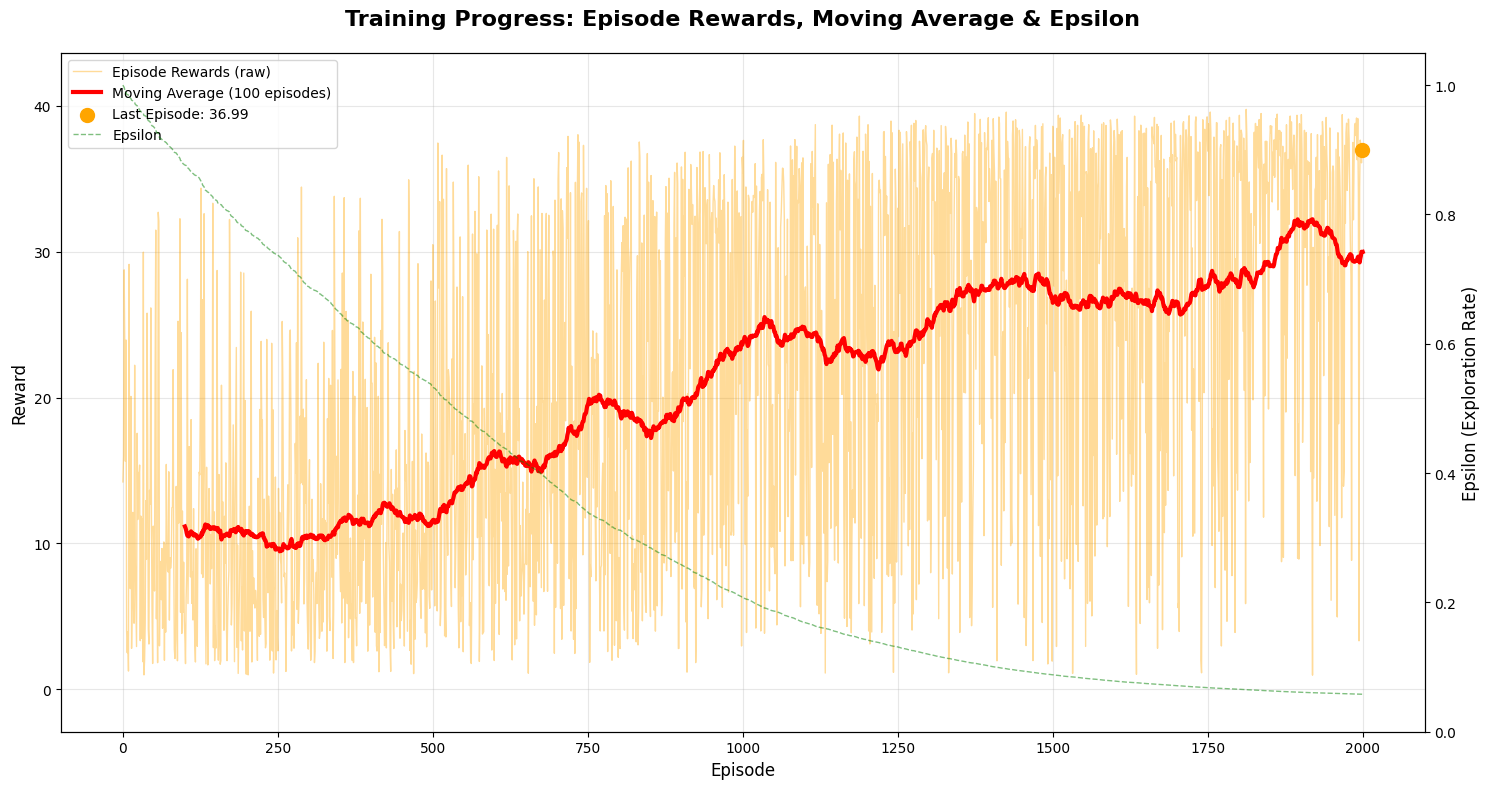

Model saved at: models/highway_dqn_model_latest.pth
Model saved at: models/highway_dqn_model_episode_2000.pth
Training completed!


In [8]:
episode_rewards: list = []
epsilon_values: list = []

print("Starting training")


def train_agent(
    env,
    agent,
    config: dict,
    plot_training_progress: callable
) -> None:
    """
    Trains the agent in the environment with live plotting.

    Args:
        env: The Gymnasium environment.
        agent: The DDQN agent.
        config (dict): Configuration dictionary with hyperparameters.
        plot_training_progress (callable): Function to plot training progress.
    """
    for episode in tqdm(range(1, config["TRAINING_EPISODES"] + 1), desc="Training Progress"):
        state, info = env.reset()
        episode_reward: float = 0.0
        done: bool = False
        truncated: bool = False

        # Calculate current epsilon for this episode
        current_epsilon = config["EPSILON_END"] + (config["EPSILON_START"] - config["EPSILON_END"]) * \
            np.exp(-1. * agent.total_timesteps / config["EPSILON_DECAY"])

        while not done and not truncated:
            # Render the environment if desired
            if episode % config["RENDER_EVERY"] == 0:
                img = env.render()
                if img is not None:
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f'Episode {episode}')
                    plt.show()

            # Select action
            action: int = agent.select_action(state)

            # Execute action and get result
            next_state, reward, done, truncated, info = env.step(action)

            # Store experience in buffer
            agent.replay_buffer.push(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward

            # Perform learning step
            agent.learn()

        episode_rewards.append(episode_reward)
        epsilon_values.append(current_epsilon)

        # Update live plot with epsilon values
        plot_training_progress(episode_rewards, epsilon_values)

        # Save latest model
        if episode % config["SAVE_MODEL_EVERY"] == 0:
            agent.save_model(config["MODEL_SAVE_PATH"])

        # Save versioned model
        if episode % config["SAVE_VERSION_EVERY"] == 0:
            agent.save_model_version(episode)

    # Final plot after training
    plot_training_progress(episode_rewards, epsilon_values)

    # Save final models
    agent.save_model(config["MODEL_SAVE_PATH"])
    agent.save_model_version(config["TRAINING_EPISODES"])

    env.close()
    print("Training completed!")


# Call the training function
train_agent(env, agent, CONFIG, plot_training_progress)

## 5. Test the Model
Test the trained model in the environment without further learning steps. You can select a specific episode to visualize the agent's performance during training or use the latest trained model to evaluate the agent's driving skills in the highway environment.

In [12]:
# Test the trained agent with model selection
print("Verfügbare Modelle:")
available_models = agent.get_available_models()
for i, model in enumerate(available_models):
    print(f"{i}: {model}")

# Model selection
SELECTED_MODEL_EPISODE = -1

print(f"\nLoad Model: {SELECTED_MODEL_EPISODE}")
agent.load_model_by_episode(SELECTED_MODEL_EPISODE)

test_episodes = 5
test_rewards = []

for episode in range(test_episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    steps = 0

    print(f"\nTest Episode {episode + 1}:")

    while not done and not truncated and steps < 1000:  # Limit maximum steps
        # Only exploitation, no exploration during testing
        with torch.no_grad():
            state_tensor = torch.FloatTensor(
                np.array(state)).unsqueeze(0).to(agent.device)
            q_values = agent.policy_net(state_tensor)
            action = q_values.argmax(dim=1).item()

        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        episode_reward += reward
        steps += 1

        # Optional: render environment (can be resource-intensive)
        env.render()

    test_rewards.append(episode_reward)
    print(f"  Reward: {episode_reward:.2f}, Steps: {steps}")

print(f"\nTest Results:")
print(f"Average Test Reward: {np.mean(test_rewards):.2f}")
print(f"Standard Deviation: {np.std(test_rewards):.2f}")

env.close()

Verfügbare Modelle:
0: highway_dqn_model_episode_1000.pth
1: highway_dqn_model_episode_1200.pth
2: highway_dqn_model_episode_1400.pth
3: highway_dqn_model_episode_1600.pth
4: highway_dqn_model_episode_1800.pth
5: highway_dqn_model_episode_200.pth
6: highway_dqn_model_episode_2000.pth
7: highway_dqn_model_episode_400.pth
8: highway_dqn_model_episode_600.pth
9: highway_dqn_model_episode_800.pth
10: highway_dqn_model_latest.pth

Load Model: -1
Model loaded from: models/highway_dqn_model_latest.pth

Test Episode 1:
  Reward: 35.59, Steps: 40

Test Episode 2:
  Reward: 36.21, Steps: 40

Test Episode 3:
  Reward: 30.46, Steps: 32

Test Episode 4:
  Reward: 36.63, Steps: 40

Test Episode 5:
  Reward: 39.66, Steps: 40

Test Results:
Average Test Reward: 35.71
Standard Deviation: 2.98
